In [1]:
import os
import numpy as np
import pandas as pd
import winshell
from math import ceil
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score, accuracy_score, classification_report, confusion_matrix


c:\Users\navjo\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\navjo\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [2]:
base_path = winshell.shortcut(r"G:/My Drive/Thesis/HAM10000.lnk").path

for item in os.listdir(base_path):
    print(item)

HAM10000_metadata.csv
hmnist_28_28_L.csv
hmnist_28_28_RGB.csv
hmnist_8_8_L.csv
hmnist_8_8_RGB.csv
HAM10000_images_part_2
HAM10000_images_part_1


In [3]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.10.1
Built with CUDA: True
Num GPUs Available:  1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
image_dir_1 = os.path.join(base_path, "HAM10000_images_part_1")
image_dir_2 = os.path.join(base_path, "HAM10000_images_part_2")

total_images = len(os.listdir(image_dir_1)) + len(os.listdir(image_dir_2))
print(f"Total images: {total_images}")

Total images: 10015


In [5]:
df = pd.read_csv(base_path + "\HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['dx'], random_state=42)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 8012
Validation set size: 1001
Test set size: 1002


In [7]:
df_train['path'] = df_train['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)

df_val['path'] = df_val['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)

df_test['path'] = df_test['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)


In [8]:
df_train.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             44
sex              0
localization     0
path             0
dtype: int64

In [9]:
df_train = df_train.dropna()
df_val = df_val.dropna()
df_test = df_test.dropna()

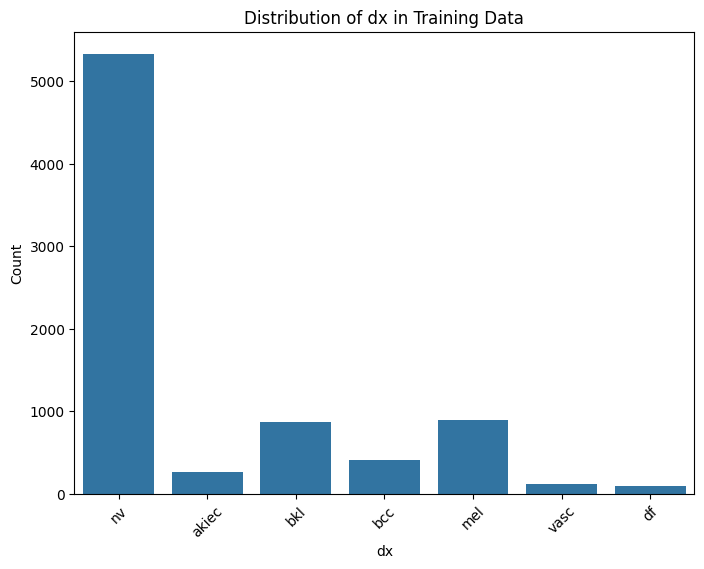

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='dx', data=df_train)
plt.title('Distribution of dx in Training Data')
plt.xlabel('dx')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

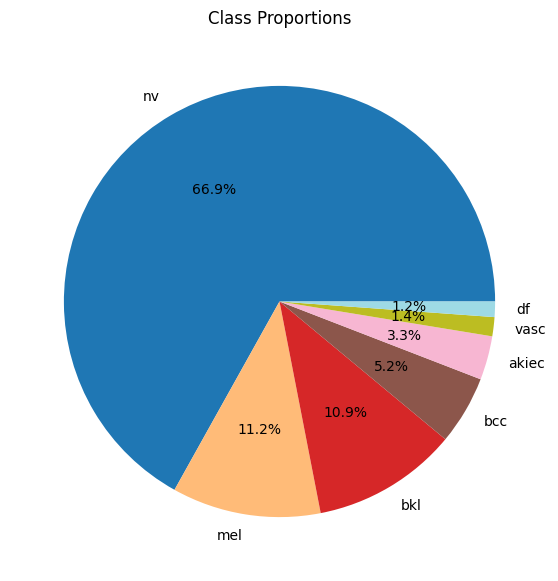

In [11]:
plt.figure(figsize=(7,7))
df_train["dx"].value_counts().plot.pie(autopct="%1.1f%%", cmap="tab20")
plt.title("Class Proportions")
plt.ylabel("")
plt.show()

Original training counts: {'nv': 5331, 'mel': 889, 'bkl': 869, 'bcc': 411, 'akiec': 262, 'vasc': 114, 'df': 92}
class akiec: oversampled 262 -> 3000 (times=12)
class bcc: oversampled 411 -> 3000 (times=8)
class bkl: oversampled 869 -> 3000 (times=4)
class df: oversampled 92 -> 3000 (times=33)
class mel: oversampled 889 -> 3000 (times=4)
class nv: undersampled 5331 -> 3000
class vasc: oversampled 114 -> 3000 (times=27)
Balanced training counts: {'akiec': 3000, 'nv': 3000, 'bkl': 3000, 'vasc': 3000, 'df': 3000, 'mel': 3000, 'bcc': 3000}
dx distribution in the training set:
 dx
akiec    3000
nv       3000
bkl      3000
vasc     3000
df       3000
mel      3000
bcc      3000
Name: count, dtype: int64


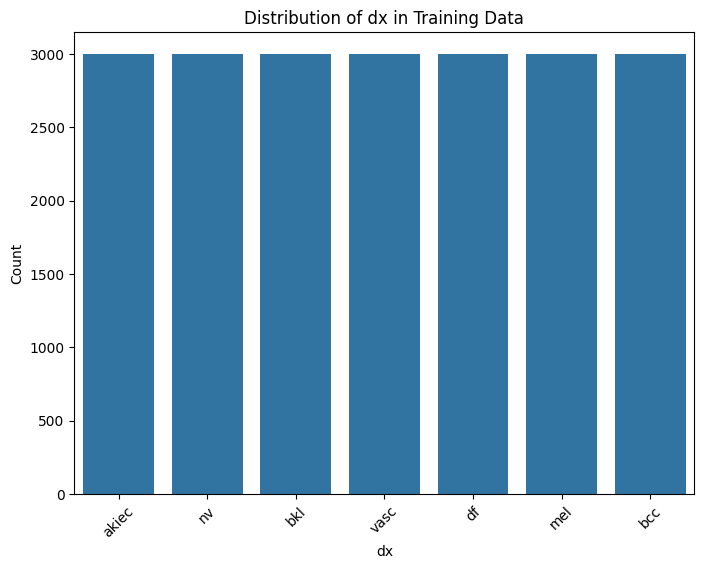

In [12]:
CEILING = 3000
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
RANDOM_STATE = 42

balanced_parts = []
class_counts = df_train['dx'].value_counts().to_dict()
print("Original training counts:", class_counts)

for cls in sorted(df_train['dx'].unique()):
    cls_df = df_train[df_train['dx'] == cls].copy()
    n = len(cls_df)

    if cls == "nv" and n > CEILING:
        cls_df = cls_df.sample(n=CEILING, random_state=RANDOM_STATE)
        print(f"class {cls}: undersampled {n} -> {len(cls_df)}")
    elif n < CEILING:
        times = int(ceil(CEILING / n))
        expanded = pd.concat([cls_df] * times, ignore_index=True).sample(
            frac=1.0, random_state=RANDOM_STATE
        ).reset_index(drop=True)
        cls_df = expanded.iloc[:CEILING].copy()
        print(f"class {cls}: oversampled {n} -> {len(cls_df)} (times={times})")
    else:
        print(f"class {cls}: kept {n}")

    balanced_parts.append(cls_df)

df_train_balanced = pd.concat(balanced_parts, ignore_index=True).sample(frac=1.0, random_state=RANDOM_STATE)
print("Balanced training counts:", df_train_balanced['dx'].value_counts().to_dict())

label_counts = df_train_balanced['dx'].value_counts()
print("dx distribution in the training set:\n", label_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='dx', data=df_train_balanced)
plt.title('Distribution of dx in Training Data')
plt.xlabel('dx')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [13]:
df_train_balanced['dx'] = df_train_balanced['dx'].astype(str)
df_val['dx'] = df_val['dx'].astype(str)
df_test['dx'] = df_test['dx'].astype(str)

In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],  
    channel_shift_range=30.0,    
    horizontal_flip=True,
    vertical_flip=True,          
    fill_mode="nearest"
)


train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train_balanced,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_STATE
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 21000 validated image filenames belonging to 7 classes.
Found 995 validated image filenames belonging to 7 classes.
Found 995 validated image filenames belonging to 7 classes.


In [15]:
def mixup(batch_x, batch_y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = batch_x.shape[0]
    index = np.random.permutation(batch_size)
    mixed_x = lam * batch_x + (1 - lam) * batch_x[index]
    mixed_y = lam * batch_y + (1 - lam) * batch_y[index]
    return mixed_x, mixed_y

class MixupGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, alpha=0.4):
        self.generator = generator
        self.alpha = alpha
    
    def __len__(self):
        return len(self.generator)
    
    def __getitem__(self, idx):
        batch_x, batch_y = self.generator[idx]
        return mixup(batch_x, batch_y, self.alpha)

mixup_train_gen = MixupGenerator(train_gen, alpha=0.4)

In [16]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(7, activation="softmax", kernel_regularizer=l2(1e-4))(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [17]:
for layer in base_model.layers[:-20]:
    layer.trainable = False

f1_metric = tfa.metrics.F1Score(num_classes=7, average='macro')

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", f1_metric]
)

history_stage1 = model.fit(
    mixup_train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
657/657 [==============================] - 497s 742ms/step - loss: 1.3665 - accuracy: 0.5532 - f1_score: 0.5077 - val_loss: 0.9671 - val_accuracy: 0.6482 - val_f1_score: 0.4924
Epoch 2/5
657/657 [==============================] - 492s 748ms/step - loss: 1.1338 - accuracy: 0.6664 - f1_score: 0.6101 - val_loss: 0.9717 - val_accuracy: 0.6523 - val_f1_score: 0.5405
Epoch 3/5
657/657 [==============================] - 414s 630ms/step - loss: 1.0558 - accuracy: 0.7079 - f1_score: 0.6454 - val_loss: 0.8927 - val_accuracy: 0.6472 - val_f1_score: 0.5547
Epoch 4/5
657/657 [==============================] - 410s 624ms/step - loss: 0.9910 - accuracy: 0.7326 - f1_score: 0.6696 - val_loss: 0.7030 - val_accuracy: 0.7508 - val_f1_score: 0.6235
Epoch 5/5
657/657 [==============================] - 446s 679ms/step - loss: 0.9410 - accuracy: 0.7593 - f1_score: 0.6939 - val_loss: 0.7634 - val_accuracy: 0.7337 - val_f1_score: 0.6362


In [18]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", f1_metric]
)

history_stage2 = model.fit(
    mixup_train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

Epoch 1/100
657/657 [==============================] - 486s 732ms/step - loss: 1.2055 - accuracy: 0.6479 - f1_score: 0.6019 - val_loss: 0.8304 - val_accuracy: 0.6985 - val_f1_score: 0.5984 - lr: 1.0000e-05
Epoch 2/100
657/657 [==============================] - 479s 729ms/step - loss: 1.0534 - accuracy: 0.7202 - f1_score: 0.6549 - val_loss: 0.7826 - val_accuracy: 0.7166 - val_f1_score: 0.6231 - lr: 1.0000e-05
Epoch 3/100
657/657 [==============================] - 453s 690ms/step - loss: 1.0053 - accuracy: 0.7350 - f1_score: 0.6694 - val_loss: 0.7174 - val_accuracy: 0.7487 - val_f1_score: 0.6704 - lr: 1.0000e-05
Epoch 4/100
657/657 [==============================] - 463s 704ms/step - loss: 0.9546 - accuracy: 0.7586 - f1_score: 0.6908 - val_loss: 0.7433 - val_accuracy: 0.7417 - val_f1_score: 0.6703 - lr: 1.0000e-05
Epoch 5/100
657/657 [==============================] - 551s 839ms/step - loss: 0.9318 - accuracy: 0.7735 - f1_score: 0.7042 - val_loss: 0.6724 - val_accuracy: 0.7668 - val_f1_s

In [19]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

unique_classes = np.unique(y_true)
iou_scores = [jaccard_score(y_true == cls, y_pred_classes == cls) for cls in unique_classes]
f1_scores = [f1_score(y_true == cls, y_pred_classes == cls) for cls in unique_classes]

test_acc = accuracy_score(y_true, y_pred_classes)
mean_iou = np.mean(iou_scores)
std_iou = np.std(iou_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("Mean IoU:", mean_iou)
print("Std IoU:", std_iou)
print("Mean F1:", mean_f1)
print("Std F1:", std_f1)
print("Eval. Score:", test_acc)


32/32 [==============================] - 1136s 37s/step
Mean IoU: 0.5811728024119992
Std IoU: 0.1464191487166207
Mean F1: 0.7243878777967899
Std F1: 0.1161899859270802
Eval. Score: 0.8050251256281407


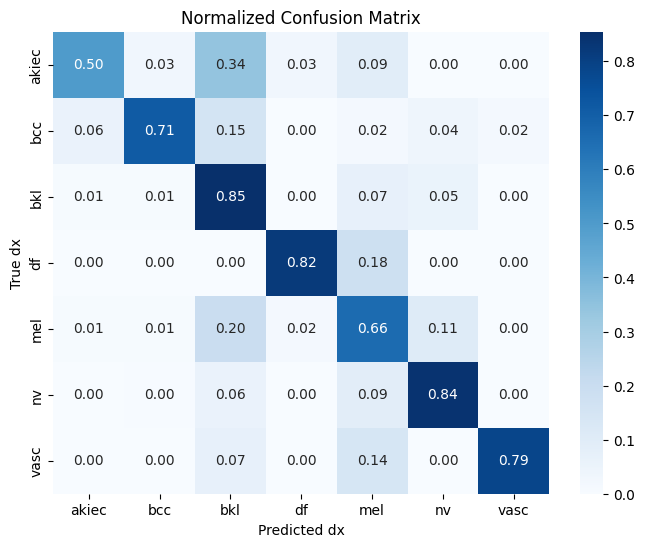

In [20]:
cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_labels = list(test_gen.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted dx")
plt.ylabel("True dx")
plt.title("Normalized Confusion Matrix")
plt.show()